In [ ]:
!pip install psycopg2-binary
!pip install ipython-sql
!pip install pandas
!pip install matplotlib

In [4]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import json

In [128]:
boroughs = ['Brooklyn', 'Manhattan', 'Queens', 'Bronx']

black_neighborhoods_dict = {}
with open('data/black_neighborhoods.json') as f:
    black_neighborhoods_dict = json.load(f)
black_neighborhoods_dict['All Boroughs'] = black_neighborhoods_dict.get('Brooklyn', []) \
    + black_neighborhoods_dict.get('Manhattan', []) \
    + black_neighborhoods_dict.get('Queens', []) \
    + black_neighborhoods_dict.get('Bronx', []) \

In [5]:
config = configparser.ConfigParser()
config.read('config/db.cfg')
pg_info = config['POSTGRES']

dbname = pg_info['db']
host = pg_info['host']
user = pg_info['user']
password = pg_info['password']
port = ''
if 'port' in pg_info:
    port = ':' + pg_info['port']

conn_string = 'postgresql://{}:{}@{}{}/{}'.format(user, password, host, port, dbname)

In [6]:
%reload_ext sql

In [7]:
%sql $conn_string

'Connected: postgres@mtatransit'

In [147]:
%%sql
SELECT 
    extract(year from recorded_date) as year,
    sum(entry_count) as annual_total
FROM 
    turnstile_transformed
where 
    entry_count < 2048
group by 
    year

 * postgresql://postgres:***@db/mtatransit
5 rows affected.


year,total_entry
2016.0,28980758
2017.0,1727153745
2018.0,1682506956
2019.0,1700290433
2020.0,293769083


In [140]:
subquery = """
    SELECT 
        recorded_date, 
        sum(entry_count) as daily_entry
    FROM 
        turnstile_transformed tt
    JOIN
        station_info si
    ON
        tt.station = si.turnstile
    WHERE 
        entry_count < 2048 and ({})
    GROUP BY
        recorded_date
    HAVING
        {} and extract(year from recorded_date) >= 2017
"""

In [141]:
query = """
    SELECT 
        extract(year from recorded_date) as year,
        extract({} from recorded_date) as {},
        avg(daily_entry) as daily_entry_avg_weekdays
    FROM
        ({}) as subquery_result
    GROUP BY
        year,
        {}
    order by 
        year desc,
        {} desc
"""

In [67]:
query_result_cache = {}

In [138]:
def generateChartTitle(x_axis, day_type, borough, neighborhoods, stations, selection_info):
    location = ''
    if borough:
        location = ' In ' + borough
    elif len(neighborhoods):
        location = ' In Select Neighborhoods'
    elif len(stations):
        location = ' In Select Stations'
    
    if selection_info:
        location += ' ({})'.format(selection_info)
        
    title = 'Average Daily Subway Entries Per {} On {}{}'
    title = title.format(x_axis.capitalize(), day_type.capitalize(), location)
    
    return title


def createDailyRidershipChart(x_axis='month', day_type='weekdays', borough='', neighborhoods=[], stations=[], selection_info=''):
    """
    Generates query for postgres to run 
    """
    if x_axis != 'month' and x_axis != 'week':
        raise ValueError("Not a valid day type choose from ['month', 'week']")
        
    day_type_query = ''
    if day_type == 'weekdays':
        day_type_query = 'extract(isodow from recorded_date)  <> 6 and extract(isodow from recorded_date) <> 7'
    elif day_type == 'saturdays':
        day_type_query = 'extract(isodow from recorded_date) = 6'
    elif day_type == 'sundays':
        day_type_query = 'extract(isodow from recorded_date) = 7'
    else:
        raise ValueError("Not a valid day type choose from ['weekdays', 'saturdays','sundays']")
    
    filter = ''
    if borough:
        filter ="si.borough='{}'".format(borough)
    elif len(neighborhoods):
        filter = "si.neighborhood='" + "' or si.neighborhood='".join(neighborhoods) + "'"
    elif len(stations):
        filter = "si.gtfs_static='" + "' or si.gtfs_static='".join(stations) + "'"
    else:
        filter = 'true'
        
    formatted_subquery = subquery.format(filter, day_type_query)
    formatted_query = query.format(x_axis, x_axis, formatted_subquery, x_axis, x_axis)

    if formatted_query not in query_result_cache:
        query_result_cache[formatted_query] = %sql $formatted_query
    query_result = query_result_cache[formatted_query]

    title = generateChartTitle(x_axis, day_type, borough, neighborhoods, stations, selection_info)

    x_axis_range = 13
    if x_axis == 'week':
        x_axis_range = 53

    df = query_result.DataFrame().pivot(index=x_axis, columns='year', values='daily_entry_avg_weekdays').astype(float)
    ax = df.plot(figsize=(25,10), title=title)
    _ = ax.xaxis.set_ticks([i for i in range(1, x_axis_range)])

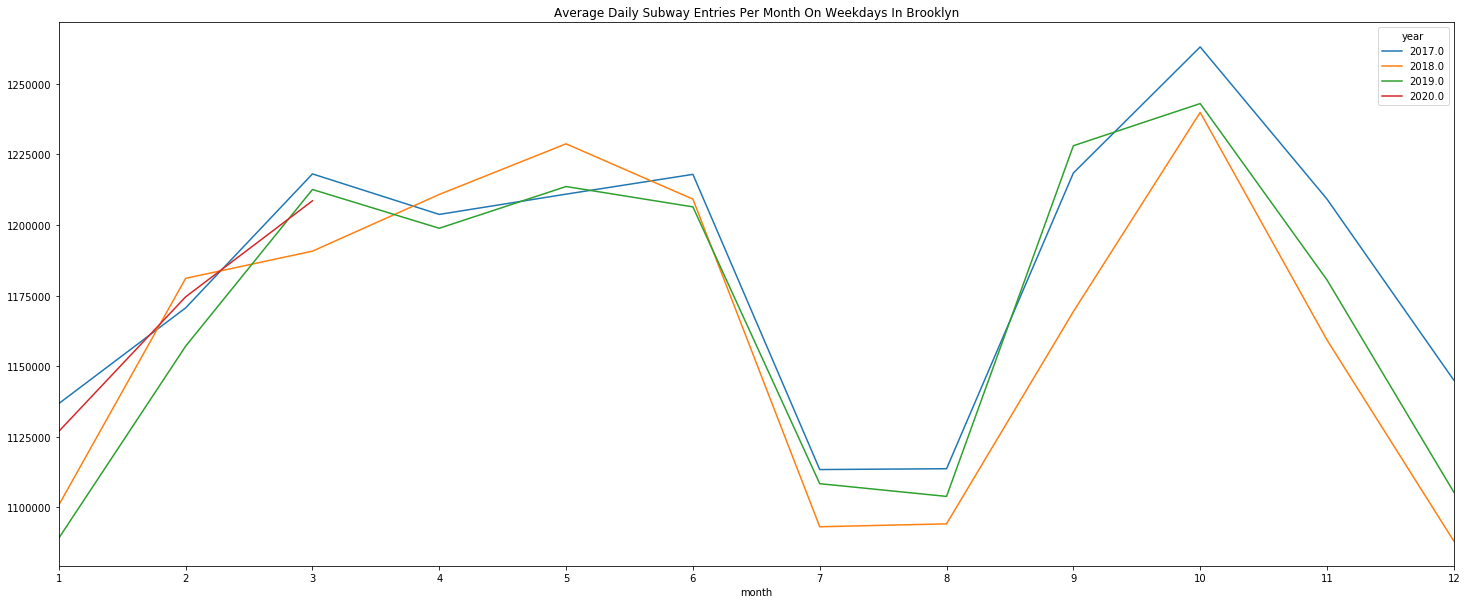

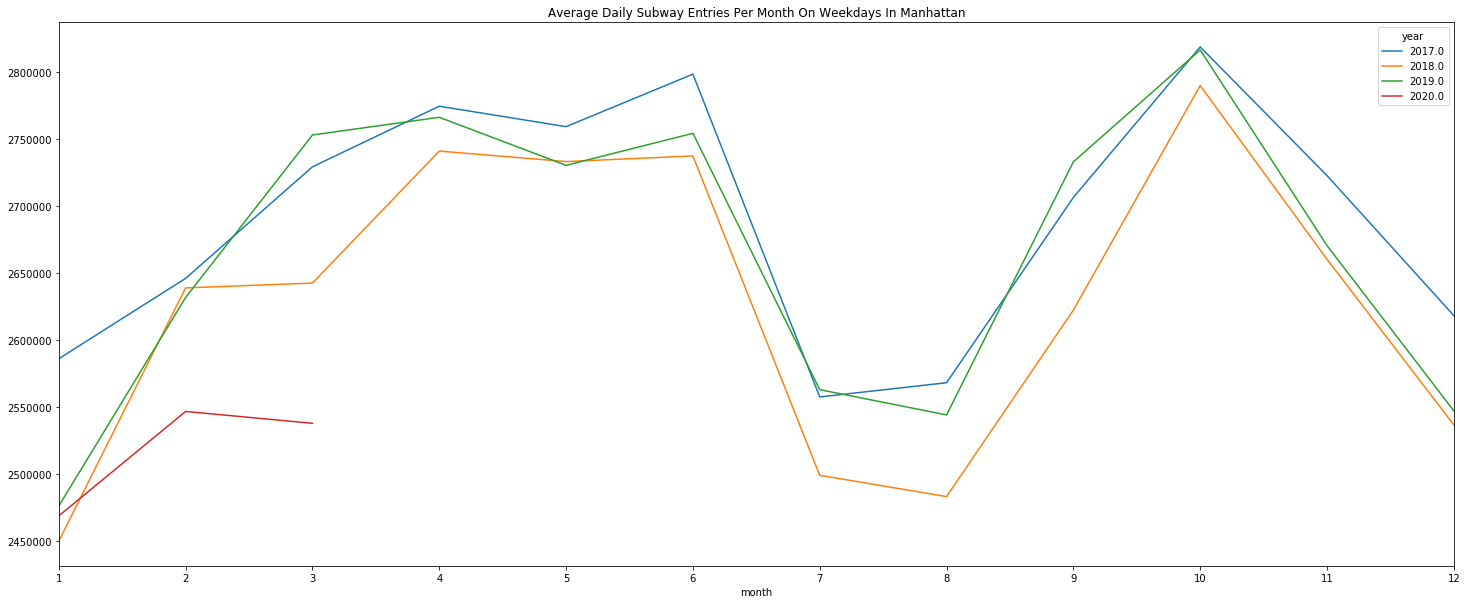

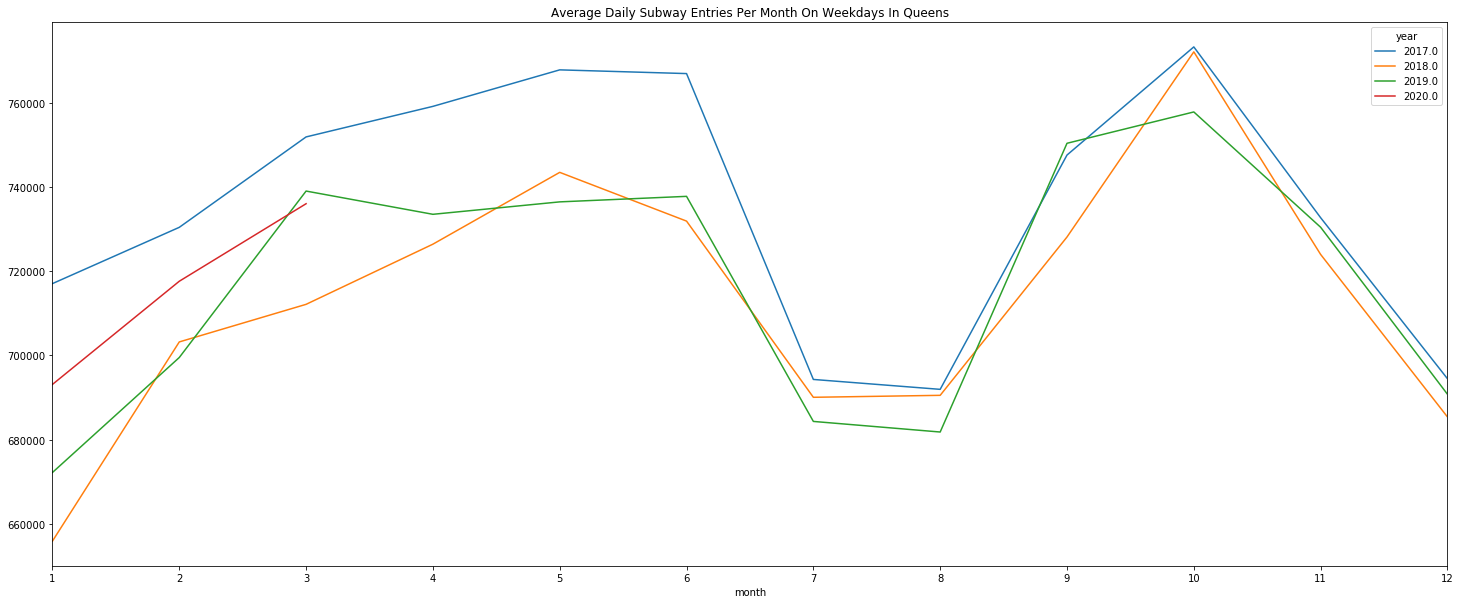

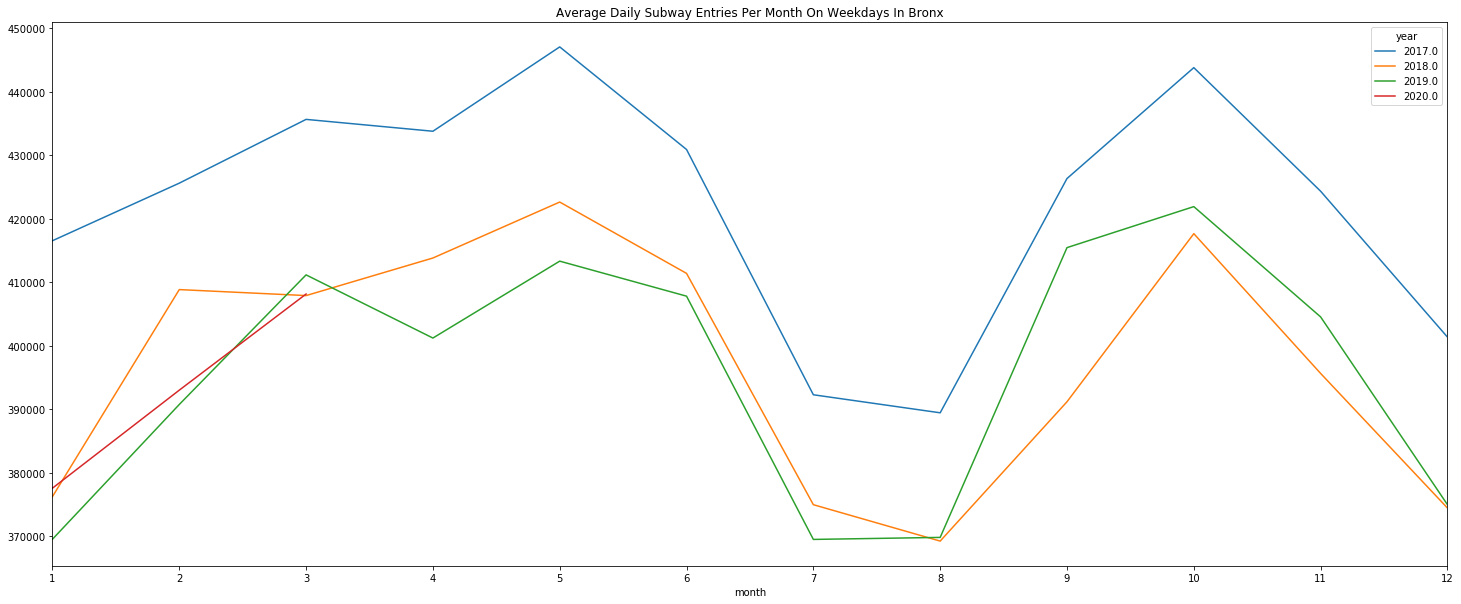

In [139]:
for borough in boroughs:
    createDailyRidershipChart(borough=borough)

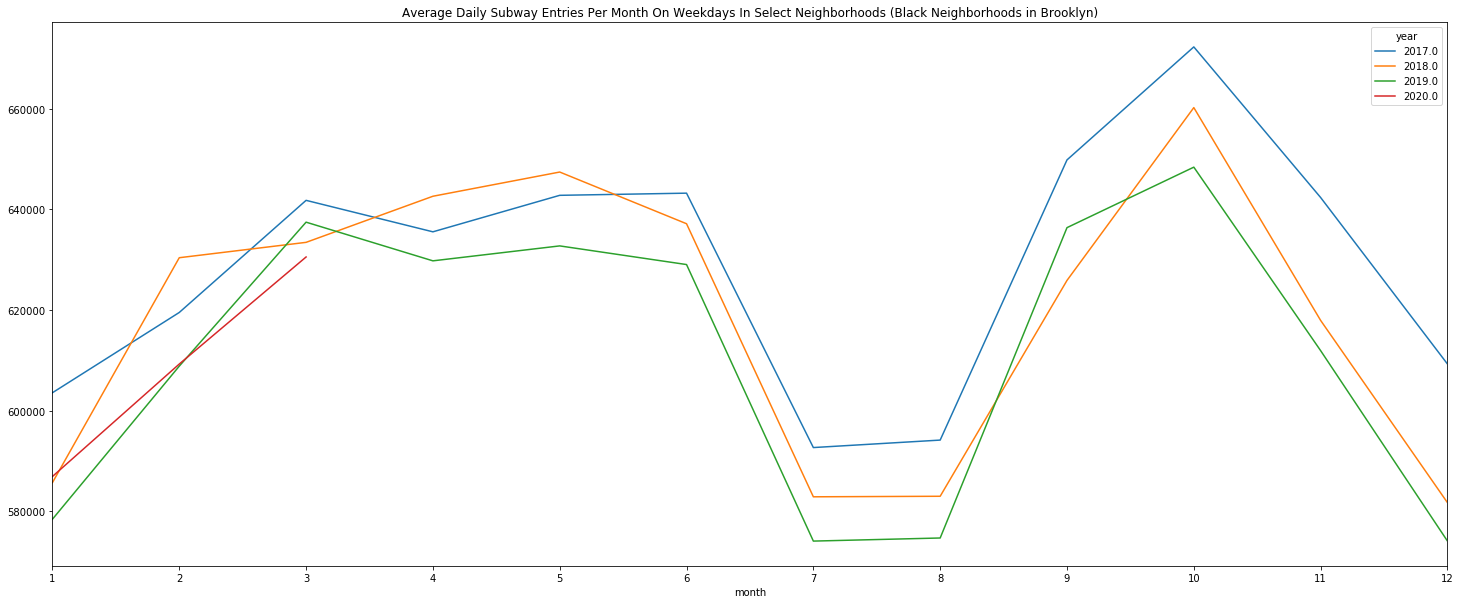

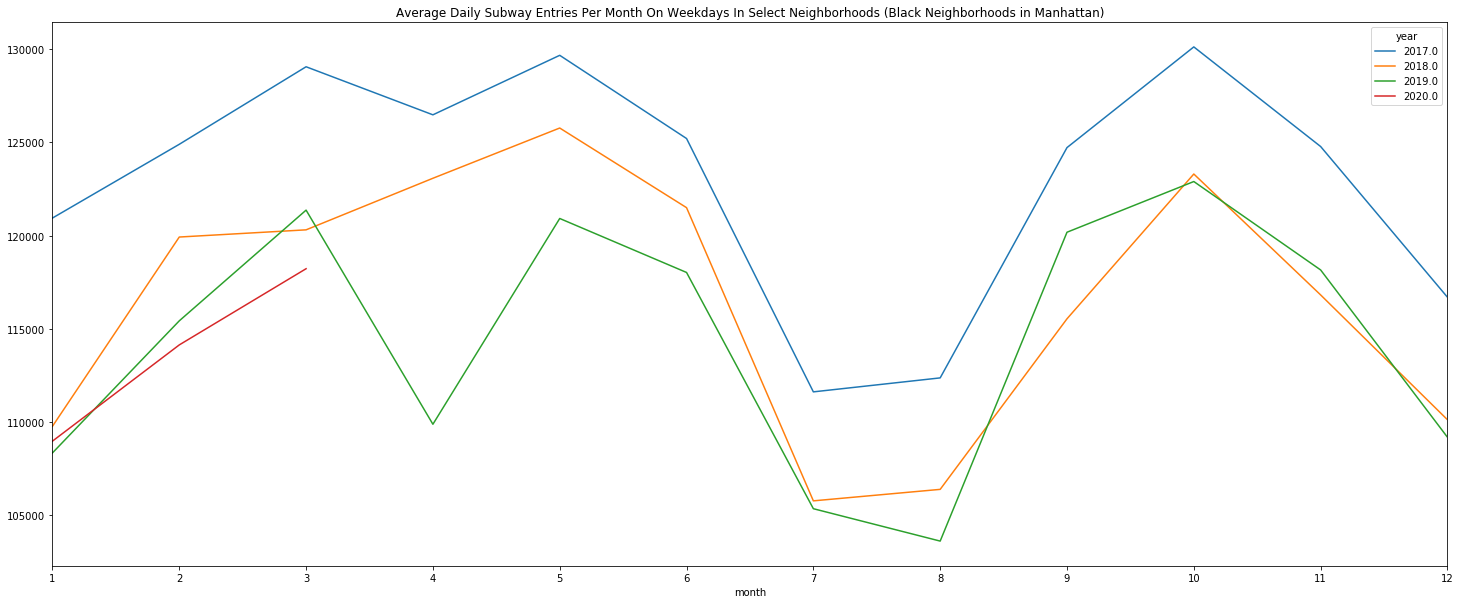

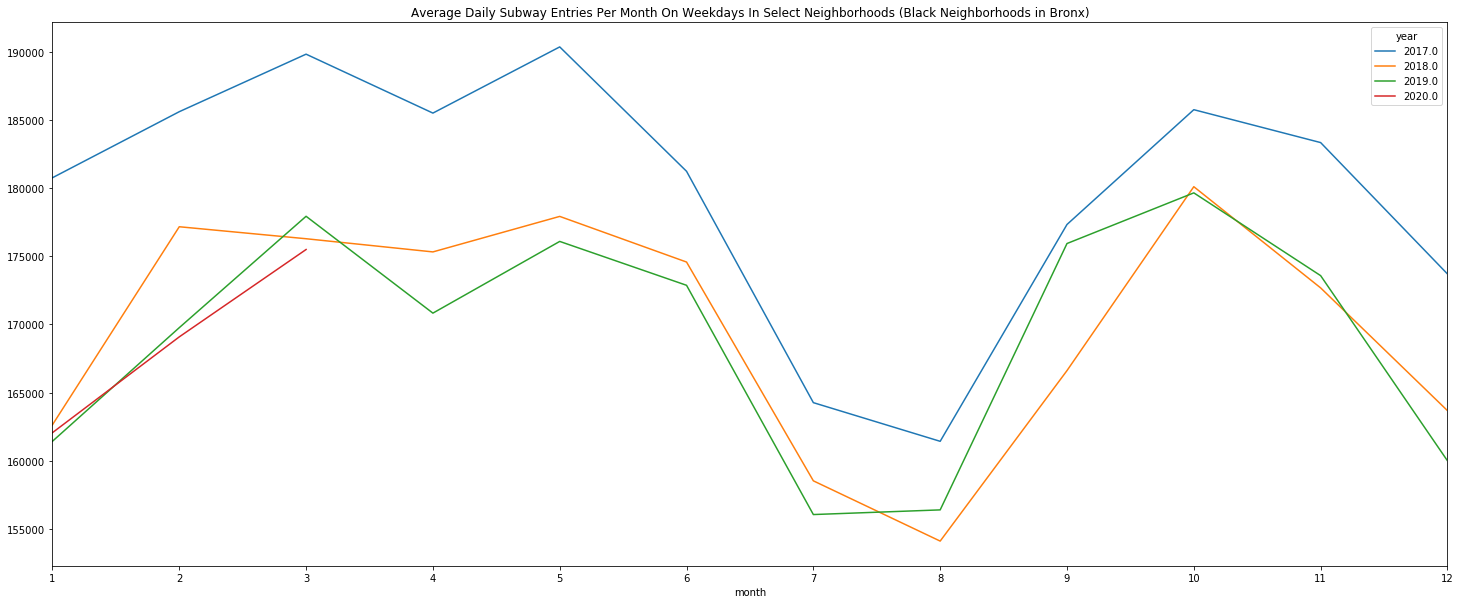

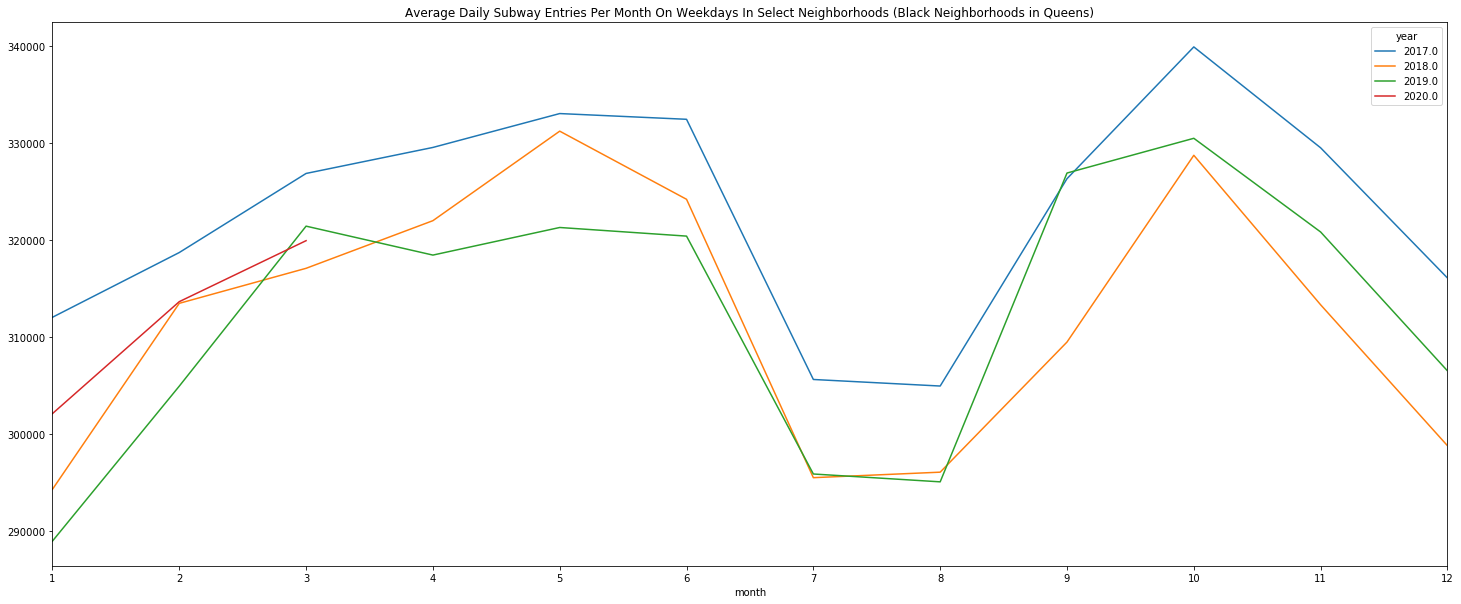

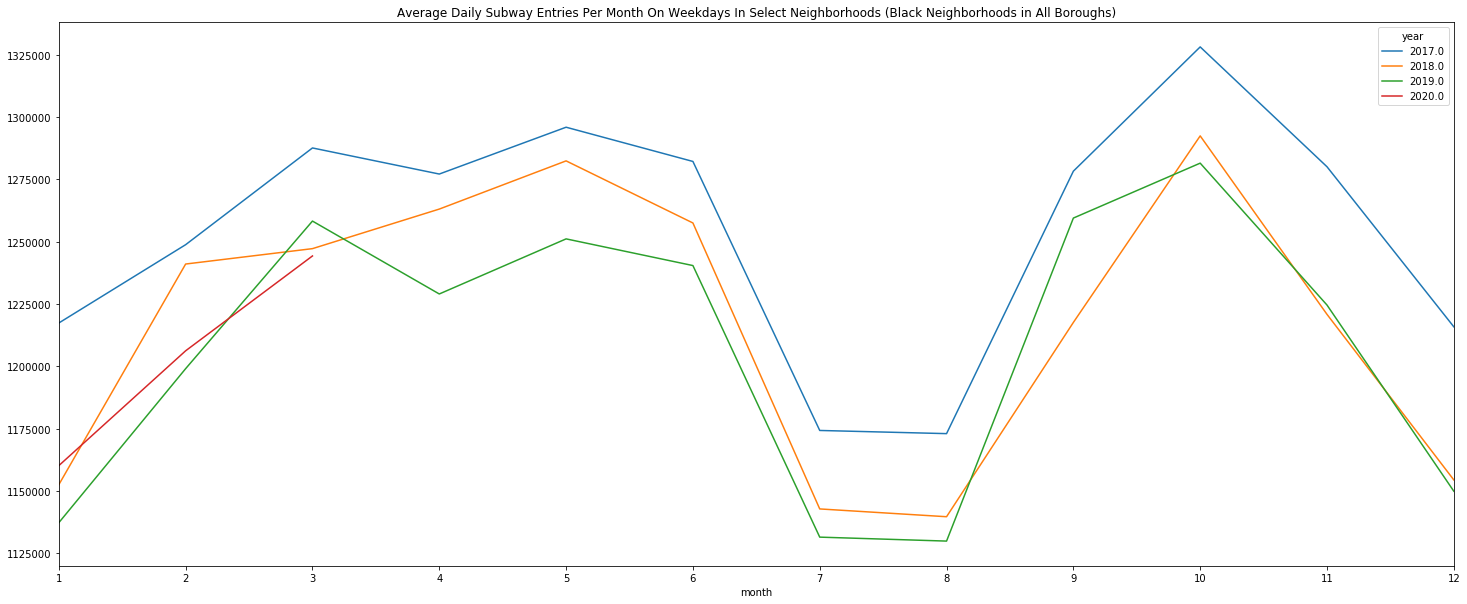

In [130]:
for borough in black_neighborhoods_dict:
    createDailyRidershipChart(neighborhoods=black_neighborhoods_dict[borough], selection_info='Black Neighborhoods in {}'.format(borough))

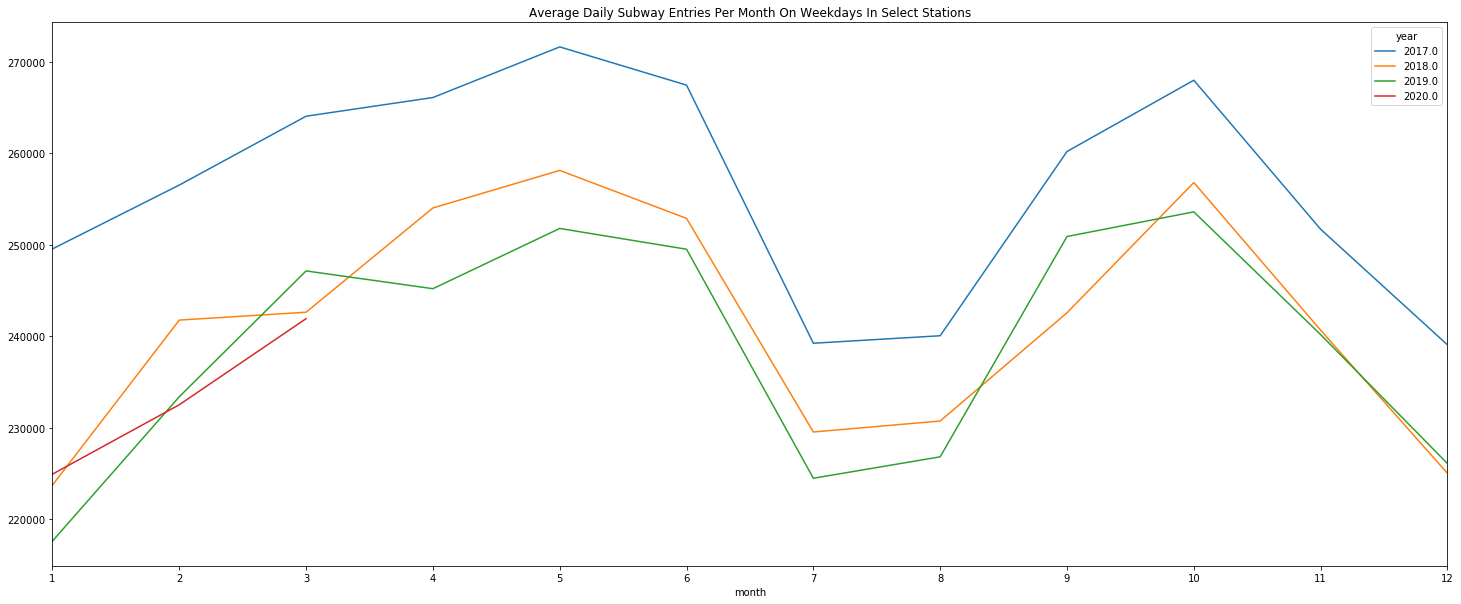

In [131]:
# picked stations near highest arrests from https://nicksawhney.github.io/fare_evasion/
cherry_picked_stations = [
    'Jamaica Center - Parsons/Archer', 
    'Sutphin Blvd - Archer Av - JFK Airport', 
    'Crown Hts - Utica Av',
    '116 St',
    '125 St',
    '3 Av - 149 St',
    '161 St - Yankee Stadium'
]

createDailyRidershipChart(stations=cherry_picked_stations)